In [1]:

from google.colab import drive #remove this if not using google drive (for loading dataset)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from keras.layers import Input, Dense
import tensorflow as tf

from keras.models import Model
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

drive.mount('/content/drive')
path_to_directory="/content/drive/My Drive/Colab Notebooks/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset 1: Annthryroid

In [47]:
data = pd.read_csv(path_to_directory + "Annthyroid_withoutdupl_07.csv")
data

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att14,att15,att16,att17,att18,att19,att20,att21,id,outlier
0,0.73,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.00060,0.0150,0.120,0.082,0.1460,1.0,'no'
1,0.24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00025,0.0300,0.143,0.133,0.1080,2.0,'no'
2,0.47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00190,0.0240,0.102,0.131,0.0780,3.0,'no'
3,0.64,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00090,0.0170,0.077,0.090,0.0850,4.0,'no'
4,0.23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00025,0.0260,0.139,0.090,0.1530,5.0,'no'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7124,0.59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.00250,0.0208,0.079,0.099,0.0800,7196.0,'no'
7125,0.51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.10600,0.0060,0.005,0.089,0.0055,7197.0,'yes'
7126,0.51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.00076,0.0201,0.090,0.067,0.1340,7198.0,'no'
7127,0.35,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00280,0.0201,0.090,0.089,0.1010,7199.0,'no'


In [48]:

X_train, X_test, y_train, y_test = train_test_split(
    data.loc[data["outlier"] == "'no'",  data.columns[:21]],
    data.loc[data["outlier"] == "'no'", data.columns[-1]],
    random_state=104,
    test_size=0.2,
    shuffle=True
)

#ind = pd.concat([X_test.iloc[:, 0], data.loc[data["label"] == 1, column]])

X_test = pd.concat([X_test, data.loc[data["outlier"] == "'yes'", data.columns[:21]]], ignore_index=True)
y_test = pd.concat([y_test, data.loc[data["outlier"] == "'yes'", data.columns[-1]]], ignore_index=True)


In [49]:
# Preprocess the data

scaler = StandardScaler()
scaled_data_train = scaler.fit_transform(X_train)
scaled_data_test = scaler.transform(X_test)


# Split the dataset into training and testing sets
initial_learning_rate = 0.001
decay_steps = 1000
decay_rate = 0.9

input_dim = scaled_data_train.shape[1]
latent_dim = 4 # Adjust the latent dimension as needed
dropout_rate = 0.1
# Encoder
encoder_inputs = tf.keras.layers.Input(shape=(input_dim,))

x = tf.keras.layers.Dense(128, activation='relu')(encoder_inputs)
x = tf.keras.layers.Dense(64, activation='relu')(encoder_inputs)
x = tf.keras.layers.Dense(32, activation='relu')(encoder_inputs)
x = tf.keras.layers.Dense(16, activation='relu')(encoder_inputs)


#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

x = tf.keras.layers.Dense(8, activation='relu')(x)

#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

#x = tf.keras.layers.Dense(8, activation='relu')(x)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

#x = tf.keras.layers.Dense(4, activation='relu')(x)

z_mean = tf.keras.layers.Dense(latent_dim)(x)
z_log_var = tf.keras.layers.Dense(latent_dim)(x)

# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder
decoder_inputs = tf.keras.layers.Input(shape=(latent_dim,))
#x = tf.keras.layers.Dense(8, activation='relu')(decoder_inputs)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

x = tf.keras.layers.Dense(8, activation='relu')(decoder_inputs)

#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

x = tf.keras.layers.Dense(16, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)
outputs = tf.keras.layers.Dense(input_dim, activation='linear')(x)

# Instantiate the model
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z])
decoder = tf.keras.Model(decoder_inputs, outputs)
# VAE model with denoising
noise_factor = 0.1  # Adjust the level of noise as needed

# Add noise to the input during training
noisy_encoder_inputs = tf.keras.layers.GaussianNoise(stddev=noise_factor)(encoder_inputs)

# VAE model
outputs = decoder(encoder(noisy_encoder_inputs)[2])
vae = tf.keras.Model(encoder_inputs, outputs)

# Define loss function
def vae_loss(inputs, outputs):
    reconstruction_loss = tf.keras.losses.mean_squared_error(inputs, outputs)

    # Accessing z_mean and z_log_var from the model's output
    z_mean = encoder(inputs)[0]
    z_log_var = encoder(inputs)[1]

    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    return reconstruction_loss + kl_loss

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# Compile the model
vae.compile(optimizer=optimizer, loss=vae_loss)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # The metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)
# Train the model
vae.fit(scaled_data_train, scaled_data_train, epochs=50, batch_size=8, validation_split=0.25, callbacks=[early_stopping])


Epoch 1/50
495/495 [==============================] - 10s 6ms/step - loss: 10333.3750 - val_loss: 1.2360
Epoch 2/50
495/495 [==============================] - 4s 8ms/step - loss: 25.0029 - val_loss: 1.0576
Epoch 3/50
495/495 [==============================] - 4s 9ms/step - loss: 27.9095 - val_loss: 0.9926
Epoch 4/50
495/495 [==============================] - 4s 7ms/step - loss: 24.3167 - val_loss: 0.9570
Epoch 5/50
495/495 [==============================] - 2s 4ms/step - loss: 24.0422 - val_loss: 0.9430
Epoch 6/50
495/495 [==============================] - 2s 3ms/step - loss: 23.4949 - val_loss: 0.9351
Epoch 7/50
495/495 [==============================] - 2s 3ms/step - loss: 22.8706 - val_loss: 0.9304
Epoch 8/50
495/495 [==============================] - 3s 7ms/step - loss: 22.2113 - val_loss: 0.9274
Epoch 9/50
495/495 [==============================] - 5s 9ms/step - loss: 21.3061 - val_loss: 0.9253
Epoch 10/50
495/495 [==============================] - 2s 5ms/step - loss: 20.4472 - va

58/58 [==============================] - 0s 4ms/step


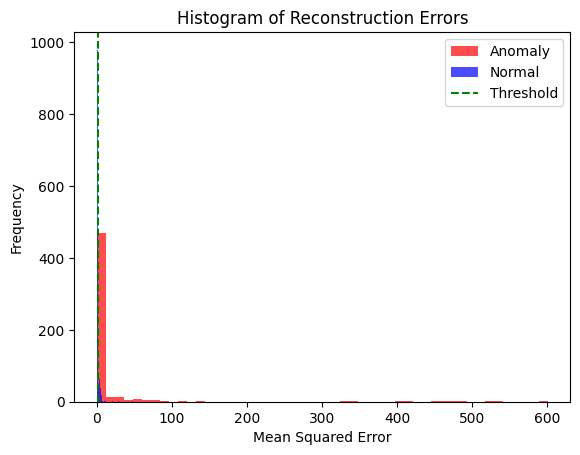

max anomaly:  600.815957015363
Precision: 0.48741007194244607
Recall: 0.5074906367041199
Accuracy:  0.7042633567188343
pr_auc:  0.6457089271466012
ROC AUC: 0.7239566917395711


In [51]:

reconstructed_data = vae.predict(scaled_data_test)

le = LabelEncoder()
y_test = le.fit_transform(y_test)
# Calculate Mean Squared Error for each sample
mse_per_sample = np.mean(np.square(scaled_data_test - reconstructed_data), axis=1)


# Separate anomalies and normal samples based on labels
anomalies = mse_per_sample[y_test == 1]
normal_samples = mse_per_sample[y_test == 0]

threshold = np.percentile(mse_per_sample, 70)
# Plot histogram for anomalies
plt.hist(anomalies, bins=50, color='r', alpha=0.7, label='Anomaly')

# Plot histogram for normal samples
plt.hist(normal_samples, bins=50, color='b', alpha=0.7, label='Normal')
plt.axvline(x = threshold, color='green', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#print(mse_per_sample)


# Create binary arrays indicating whether each element is anomalous or not
anomalies = np.where(mse_per_sample >threshold, 1, 0)


fpr, tpr, thresholds = metrics.roc_curve(y_test, anomalies)
pr_auc = metrics.auc(fpr, tpr)
#print(thresholds)

print("pr_auc: ",pr_auc)
print("ROC AUC:",roc_auc_score(y_test, mse_per_sample))


# Dataset 2: Breast Cancer Wisconson

In [34]:
data = pd.read_csv(path_to_directory + "breast-cancer-wisconsin.csv")
#some data reading process
data = pd.DataFrame(np.vstack([data.columns, data]))

data.columns=  ["id", "Clump Thickness","Uniformity of Cell Size","Uniformity of Cell Shape","Marginal Adhesion",
                "Single Epithelial Cell Size","Bare Nuclei","Bland Chromatin","Normal Nucleoli",  "Mitoses", "Class"]
l  = [5,1,1,1,2,1,3,1,1,2]
for i in range(1,len(data.columns)):

    data.iloc[0,i] = l[i-1]
    data = data[data.iloc[:,i] != "?"]
data

,id,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2,1,1,1,2
695,841769,2,1,1,1,2,1,1,1,1,2
696,888820,5,10,10,3,7,3,8,10,2,4
697,897471,4,8,6,4,3,4,10,6,1,4


In [43]:
# ensuring that only train data contains normal data
data = data.astype(np.float32)
le = LabelEncoder()
data["label"] = le.fit_transform(data["Class"])

data ["Class"] = data["label"]
data_normal = data[data["Class"] == 1]
X_train, X_test, y_train, y_test = train_test_split(data_normal.loc[:, data.columns],data_normal.loc[:, "Class"],
                                   random_state=104,
                                   test_size=0.25,
                                   shuffle=True)

#print(len(y_test),len(X_train), len(X_test) )
X_test = pd.concat([X_test, data.loc[data["Class"] == 0, data.columns]], ignore_index=True)
y_test = pd.concat([y_test, data.loc[data["Class"] == 0, "Class"]], ignore_index=True)
#print(len(y_test), len(X_train), len(X_test))

# normalizing the train and test data
sc = StandardScaler()
scaled_data_train = sc.fit_transform(X_train)
scaled_data_test = sc.fit_transform(X_test)




input_dim = scaled_data_train.shape[1]
latent_dim = 2 # Adjust the latent dimension as needed

# Encoder
encoder_inputs = tf.keras.layers.Input(shape=(input_dim,))
x = tf.keras.layers.Dense(8, activation='relu')(encoder_inputs)
x = tf.keras.layers.Dense(4, activation='relu')(x)
#x = tf.keras.layers.Dense(8, activation='relu')(x)

z_mean = tf.keras.layers.Dense(latent_dim)(x)
z_log_var = tf.keras.layers.Dense(latent_dim)(x)

# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder
decoder_inputs = tf.keras.layers.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(8, activation='relu')(decoder_inputs)
x = tf.keras.layers.Dense(16, activation='relu')(x)
#x = tf.keras.layers.Dense(32, activation='relu')(x)
outputs = tf.keras.layers.Dense(input_dim, activation='linear')(x)

# Instantiate the model
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z])
decoder = tf.keras.Model(decoder_inputs, outputs)

# VAE model
outputs = decoder(encoder(encoder_inputs)[2])
vae = tf.keras.Model(encoder_inputs, outputs)

# Define loss function
def vae_loss(inputs, outputs):
    reconstruction_loss = tf.keras.losses.mean_squared_error(inputs, outputs)

    # Accessing z_mean and z_log_var from the model's output
    z_mean = encoder(inputs)[0]
    z_log_var = encoder(inputs)[1]

    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    return reconstruction_loss + kl_loss

# Compile the model
vae.compile(optimizer='adam', loss=vae_loss)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # The metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)
# Train the model
vae.fit(scaled_data_train, scaled_data_train, epochs=50, batch_size=8, validation_split=0.25, callbacks=[early_stopping])



Epoch 1/50
17/17 [==============================] - 4s 31ms/step - loss: 1.2150 - val_loss: 1.1224
Epoch 2/50
17/17 [==============================] - 0s 8ms/step - loss: 1.0903 - val_loss: 1.0503
Epoch 3/50
17/17 [==============================] - 0s 8ms/step - loss: 1.0379 - val_loss: 0.9648
Epoch 4/50
17/17 [==============================] - 0s 7ms/step - loss: 0.9796 - val_loss: 0.9232
Epoch 5/50
17/17 [==============================] - 0s 7ms/step - loss: 0.9566 - val_loss: 0.8948
Epoch 6/50
17/17 [==============================] - 0s 7ms/step - loss: 0.9265 - val_loss: 0.8713
Epoch 7/50
17/17 [==============================] - 0s 7ms/step - loss: 0.9155 - val_loss: 0.8524
Epoch 8/50
17/17 [==============================] - 0s 6ms/step - loss: 0.9003 - val_loss: 0.8466
Epoch 9/50
17/17 [==============================] - 0s 8ms/step - loss: 0.8975 - val_loss: 0.8469
Epoch 10/50
17/17 [==============================] - 0s 6ms/step - loss: 0.8839 - val_loss: 0.8278
Epoch 11/50
17/17 

58/58 [==============================] - 0s 3ms/step
1853
1853 1853


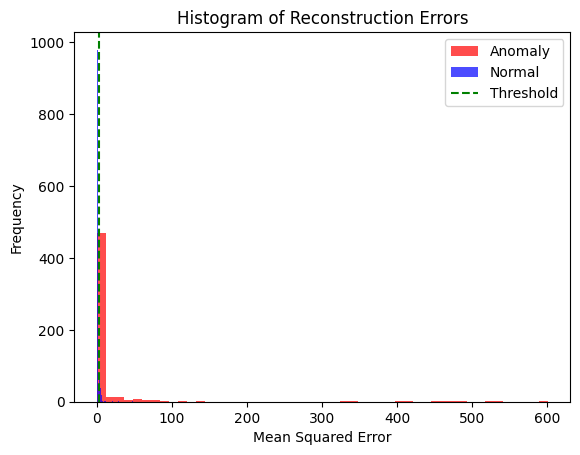

max anomaly:  600.8155854511322
pr_auc:  0.5985048541483873
ROC AUC: 0.7240617537403492


In [52]:
# testing

#encode labels
le = LabelEncoder()
y_test = le.fit_transform(y_test)

# Use the trained autoencoder to reconstruct the test set
reconstructed_data = vae.predict(scaled_data_test)
print(len(scaled_data_test))
# Calculate Mean Squared Error for each sample
mse_per_sample = np.mean(np.square(scaled_data_test - reconstructed_data), axis=1)
print(len(mse_per_sample), len(y_test))
# Separate anomalies and normal samples based on labels
anomalies = mse_per_sample[y_test == 1]
normal_samples = mse_per_sample[y_test == 0]
threshold = np.percentile(mse_per_sample,85) # Adjust this threshold as needed


# Plot histogram for anomalies
plt.hist(anomalies, bins=50, color='r', alpha=0.7, label='Anomaly')

# Plot histogram for normal samples
plt.hist(normal_samples, bins=50, color='b', alpha=0.7, label='Normal')
plt.axvline(x = threshold, color='green', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#print(mse_per_sample)



# Create binary arrays indicating whether each element is anomalous or not
anomalies = np.where(mse_per_sample > threshold, 1, 0)


fpr, tpr, thresholds = metrics.roc_curve(y_test, anomalies)
pr_auc = metrics.auc(fpr, tpr)
#print(thresholds)


print("pr_auc: ",pr_auc)
print("ROC AUC:",roc_auc_score(y_test, mse_per_sample))



# Dataset 3: Cardio

In [65]:
f=np.load("/content/drive/My Drive/Colab Notebooks/cardio.npz")
data = {1: "x", 2:"y" ,3:'z'}
for (i,j) in enumerate(f):
    data[i+1] = f[j]

x = data[1]
tx = data[2]
ty = data[3]

In [66]:


# Split the dataset into training and validation sets
scaled_data_train, scaled_data_test = train_test_split(x,test_size=0.25, random_state=42)


# Split the dataset into training and testing sets
#train_data, test_data = train_test_split(scaled_data, test_size=0.2, random_state=42)
# Build the Variational Autoencoder (VAE) model
initial_learning_rate = 0.001
decay_steps = 1000
decay_rate = 0.9

input_dim = scaled_data_train.shape[1]
latent_dim = 4 # Adjust the latent dimension as needed
dropout_rate = 0.1
# Encoder
encoder_inputs = tf.keras.layers.Input(shape=(input_dim,))
x = tf.keras.layers.Dense(16, activation='relu')(encoder_inputs)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

x = tf.keras.layers.Dense(8, activation='relu')(x)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

#x = tf.keras.layers.Dense(8, activation='relu')(x)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

#x = tf.keras.layers.Dense(4, activation='relu')(x)

z_mean = tf.keras.layers.Dense(latent_dim)(x)
z_log_var = tf.keras.layers.Dense(latent_dim)(x)

# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder
decoder_inputs = tf.keras.layers.Input(shape=(latent_dim,))
#x = tf.keras.layers.Dense(8, activation='relu')(decoder_inputs)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

x = tf.keras.layers.Dense(8, activation='relu')(decoder_inputs)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

x = tf.keras.layers.Dense(16, activation='relu')(x)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)
outputs = tf.keras.layers.Dense(input_dim, activation='sigmoid')(x)

# Instantiate the model
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z])
decoder = tf.keras.Model(decoder_inputs, outputs)
# VAE model with denoising
noise_factor = 0.1  # Adjust the level of noise as needed

# Add noise to the input during training
noisy_encoder_inputs = tf.keras.layers.GaussianNoise(stddev=noise_factor)(encoder_inputs)

# VAE model
outputs = decoder(encoder(noisy_encoder_inputs)[2])
vae = tf.keras.Model(encoder_inputs, outputs)

# Define loss function
def vae_loss(inputs, outputs):
    reconstruction_loss = tf.keras.losses.mean_squared_error(inputs, outputs)

    # Accessing z_mean and z_log_var from the model's output
    z_mean = encoder(inputs)[0]
    z_log_var = encoder(inputs)[1]

    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    return reconstruction_loss + kl_loss

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# Compile the model
vae.compile(optimizer=optimizer, loss=vae_loss)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # The metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)
# Train the model
vae.fit(scaled_data_train, scaled_data_train, epochs=50, batch_size=8, validation_data=(scaled_data_test, scaled_data_test), callbacks=[early_stopping])



Epoch 1/50
139/139 [==============================] - 3s 6ms/step - loss: 1.1936 - val_loss: 0.9055
Epoch 2/50
139/139 [==============================] - 0s 3ms/step - loss: 0.8956 - val_loss: 0.7582
Epoch 3/50
139/139 [==============================] - 1s 4ms/step - loss: 0.8270 - val_loss: 0.7335
Epoch 4/50
139/139 [==============================] - 1s 4ms/step - loss: 0.8126 - val_loss: 0.7254
Epoch 5/50
139/139 [==============================] - 0s 3ms/step - loss: 0.8075 - val_loss: 0.7227
Epoch 6/50
139/139 [==============================] - 1s 4ms/step - loss: 0.8048 - val_loss: 0.7200
Epoch 7/50
139/139 [==============================] - 0s 3ms/step - loss: 0.8034 - val_loss: 0.7207
Epoch 8/50
139/139 [==============================] - 0s 3ms/step - loss: 0.8030 - val_loss: 0.7195
Epoch 9/50
139/139 [==============================] - 1s 4ms/step - loss: 0.8028 - val_loss: 0.7184
Epoch 10/50
139/139 [==============================] - 1s 4ms/step - loss: 0.8020 - val_loss: 0.7178

11/11 [==============================] - 0s 3ms/step


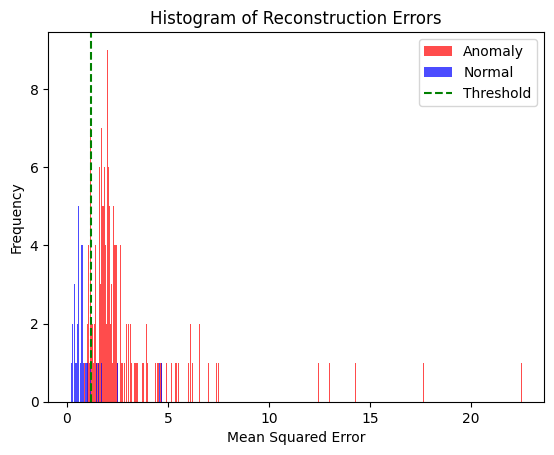

max anomaly:  22.493971314295088
Precision: 0.8688524590163934
Recall: 0.9034090909090909
Accuracy:  0.8835227272727273
pr_auc:  0.8835227272727273
ROC AUC: 0.9349496384297521


In [71]:

reconstructed_data = vae.predict(tx)

# Calculate Mean Squared Error for each sample
mse_per_sample = np.mean(np.square(tx - reconstructed_data), axis=1)

# Separate anomalies and normal samples based on labels
anomalies = mse_per_sample[ty == 1]
normal_samples = mse_per_sample[ty == 0]

threshold = np.percentile(mse_per_sample, 48)
# Plot histogram for anomalies
plt.hist(anomalies, bins=500, color='r', alpha=0.7, label='Anomaly')

# Plot histogram for normal samples
plt.hist(normal_samples, bins=500, color='b', alpha=0.7, label='Normal')
plt.axvline(x = threshold, color='green', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#print(mse_per_sample)

# Create binary arrays indicating whether each element is anomalous or not
anomalies = np.where(mse_per_sample >threshold, 1, 0)



fpr, tpr, thresholds = metrics.roc_curve(ty, anomalies)
pr_auc = metrics.auc(fpr, tpr)
#print(thresholds)

print("pr_auc: ",pr_auc)
print("ROC AUC:",roc_auc_score(ty, mse_per_sample))


# Dataset 4: Gas Building Float

In [78]:
f=np.load("/content/drive/My Drive/Colab Notebooks/Sadia/datasets/Glass_building_float.npz")
data = {1: "x", 2:"y" ,3:'z'}
for (i,j) in enumerate(f):
    data[i+1] = f[j]
x_train = data[1]
tx = data[2]
ty = data[3]


(42,)

In [73]:
scaler = MinMaxScaler()
scaled_data_train = scaler.fit_transform(x_train)
scaled_data_test = scaler.transform(tx)

In [74]:
initial_learning_rate = 0.0001
decay_steps = 5000
decay_rate = 0.9

input_dim = scaled_data_train.shape[1]
latent_dim = 4 # Adjust the latent dimension as needed
dropout_rate = 0.1
act_fn = "relu"
# Encoder
encoder_inputs = tf.keras.layers.Input(shape=(input_dim,))
#x = tf.keras.layers.Dense(512, activation=act_fn)(encoder_inputs)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

#x = tf.keras.layers.Dense(256, activation=act_fn)(encoder_inputs)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

#x = tf.keras.layers.Dense(128, activation=act_fn)(x)
#x = tf.keras.layers.Dense(64, activation=act_fn)(x)
x = tf.keras.layers.Dense(32, activation=act_fn)(encoder_inputs)
x = tf.keras.layers.Dense(16, activation=act_fn)(x)


x = tf.keras.layers.Dense(8, activation=act_fn)(x)
#x = tf.keras.layers.Dense(4, activation=act_fn)(x)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

z_mean = tf.keras.layers.Dense(latent_dim)(x)
z_log_var = tf.keras.layers.Dense(latent_dim)(x)

# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder
decoder_inputs = tf.keras.layers.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(8, activation=act_fn)(decoder_inputs)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)


x = tf.keras.layers.Dense(16, activation=act_fn)(x)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

x = tf.keras.layers.Dense(32, activation=act_fn)(x)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

#x = tf.keras.layers.Dense(64, activation=act_fn)(x)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

#x = tf.keras.layers.Dense(128, activation=act_fn)(x)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)
#x = tf.keras.layers.Dense(256, activation=act_fn)(x)

#x = tf.keras.layers.Dense(512, activation=act_fn)(x)

outputs = tf.keras.layers.Dense(input_dim, activation='linear')(x)

# Instantiate the model
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z])
decoder = tf.keras.Model(decoder_inputs, outputs)
# VAE model with denoising
noise_factor = 0.1  # Adjust the level of noise as needed

# Add noise to the input during training
noisy_encoder_inputs = tf.keras.layers.GaussianNoise(stddev=noise_factor)(encoder_inputs)

# VAE model
outputs = decoder(encoder(encoder_inputs)[2])
vae_normal = tf.keras.Model(encoder_inputs, outputs)

# Define loss function
def vae_loss(inputs, outputs):
    reconstruction_loss = tf.keras.losses.mean_squared_error(inputs, outputs)

    # Accessing z_mean and z_log_var from the model's output
    z_mean = encoder(inputs)[0]
    z_log_var = encoder(inputs)[1]

    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    return 0.1*reconstruction_loss + 0.9*kl_loss

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# Compile the model
vae_normal.compile(optimizer=optimizer, loss=vae_loss)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # The metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)
# Train the model
vae_normal.fit(scaled_data_train, scaled_data_train, epochs=50, batch_size=8, validation_split=0.25, callbacks=[early_stopping])



Epoch 1/50
5/5 [==============================] - 4s 148ms/step - loss: 0.0902 - val_loss: 0.0887
Epoch 2/50
5/5 [==============================] - 0s 21ms/step - loss: 0.0870 - val_loss: 0.0825
Epoch 3/50
5/5 [==============================] - 0s 21ms/step - loss: 0.0816 - val_loss: 0.0807
Epoch 4/50
5/5 [==============================] - 0s 22ms/step - loss: 0.0761 - val_loss: 0.0776
Epoch 5/50
5/5 [==============================] - 0s 20ms/step - loss: 0.0727 - val_loss: 0.0746
Epoch 6/50
5/5 [==============================] - 0s 28ms/step - loss: 0.0700 - val_loss: 0.0668
Epoch 7/50
5/5 [==============================] - 0s 19ms/step - loss: 0.0677 - val_loss: 0.0698
Epoch 8/50
5/5 [==============================] - 0s 20ms/step - loss: 0.0645 - val_loss: 0.0625
Epoch 9/50
5/5 [==============================] - 0s 20ms/step - loss: 0.0625 - val_loss: 0.0651
Epoch 10/50
5/5 [==============================] - 0s 24ms/step - loss: 0.0609 - val_loss: 0.0625
Epoch 11/50
5/5 [===========

2/2 [==============================] - 0s 5ms/step


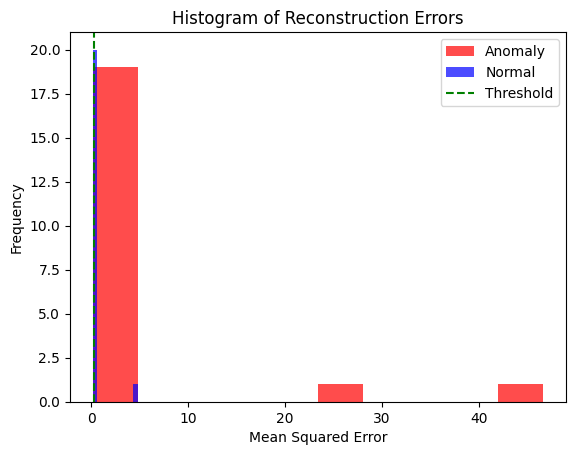

max anomaly:  46.669567806417525
Precision: 0.7368421052631579
Recall: 0.6666666666666666
Accuracy:  0.7142857142857143
pr_auc:  0.7142857142857142
ROC AUC: 0.7913832199546486


In [77]:

reconstructed_data = vae_normal.predict(scaled_data_test)

# Calculate Mean Squared Error for each sample
mse_per_sample = np.mean(np.square(scaled_data_test - reconstructed_data), axis=1)

# Separate anomalies and normal samples based on labels
anomalies = mse_per_sample[ty == 1]
normal_samples = mse_per_sample[ty == 0]

threshold = np.percentile(mse_per_sample, 55)
# Plot histogram for anomalies
plt.hist(anomalies, bins=10, color='r', alpha=0.7, label='Anomaly')

# Plot histogram for normal samples
plt.hist(normal_samples, bins=10, color='b', alpha=0.7, label='Normal')
plt.axvline(x = threshold, color='green', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#print(mse_per_sample)


# Create binary arrays indicating whether each element is anomalous or not
anomalies = np.where(mse_per_sample > threshold, 1, 0)


fpr, tpr, thresholds = metrics.roc_curve(ty, anomalies)
pr_auc = metrics.auc(fpr, tpr)

#print(thresholds)


print("pr_auc: ",pr_auc)
print("ROC AUC:",roc_auc_score(ty, mse_per_sample))


# Dataset 5: Gas Drift

In [79]:
f=np.load("/content/drive/My Drive/Colab Notebooks/gas-drift.npz")
data = {1: "x", 2:"y" ,3:'z'}
for (i,j) in enumerate(f):
    data[i+1] = f[j]
x_train = data[1]
tx = data[2]
ty = data[3]

In [81]:
scaler = StandardScaler()
scaled_data_train = scaler.fit_transform(x_train)
scaled_data_test = scaler.transform(tx)

In [82]:
initial_learning_rate = 0.0001
decay_steps = 5000
decay_rate = 0.9

input_dim = scaled_data_train.shape[1]
latent_dim = 8 # Adjust the latent dimension as needed
dropout_rate = 0.1
act_fn = "tanh"
# Encoder
encoder_inputs = tf.keras.layers.Input(shape=(input_dim,))
x = tf.keras.layers.Dense(512, activation=act_fn)(encoder_inputs)
x = tf.keras.layers.Dense(256, activation=act_fn)(x)
x = tf.keras.layers.Dense(128, activation=act_fn)(x)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

x = tf.keras.layers.Dense(64, activation=act_fn)(x)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

x = tf.keras.layers.Dense(32, activation=act_fn)(x)
x = tf.keras.layers.Dense(16, activation=act_fn)(x)


#x = tf.keras.layers.Dense(8, activation=act_fn)(x)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

z_mean = tf.keras.layers.Dense(latent_dim)(x)
z_log_var = tf.keras.layers.Dense(latent_dim)(x)

# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder
decoder_inputs = tf.keras.layers.Input(shape=(latent_dim,))
#x = tf.keras.layers.Dense(8, activation=act_fn)(decoder_inputs)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)


x = tf.keras.layers.Dense(16, activation=act_fn)(decoder_inputs)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

x = tf.keras.layers.Dense(32, activation=act_fn)(x)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(decoder_inputs)

x = tf.keras.layers.Dense(64, activation=act_fn)(x)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

x = tf.keras.layers.Dense(128, activation=act_fn)(x)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)
x = tf.keras.layers.Dense(256, activation=act_fn)(x)
x = tf.keras.layers.Dense(512, activation=act_fn)(x)
outputs = tf.keras.layers.Dense(input_dim, activation='linear')(x)

# Instantiate the model
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z])
decoder = tf.keras.Model(decoder_inputs, outputs)
# VAE model with denoising
noise_factor = 0.1  # Adjust the level of noise as needed

# Add noise to the input during training
noisy_encoder_inputs = tf.keras.layers.GaussianNoise(stddev=noise_factor)(encoder_inputs)

# VAE model
outputs = decoder(encoder(encoder_inputs)[2])
vae_normal = tf.keras.Model(encoder_inputs, outputs)

# Define loss function
def vae_loss(inputs, outputs):
    reconstruction_loss = tf.keras.losses.mean_squared_error(inputs, outputs)

    # Accessing z_mean and z_log_var from the model's output
    z_mean = encoder(inputs)[0]
    z_log_var = encoder(inputs)[1]

    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    return reconstruction_loss + kl_loss

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# Compile the model
vae_normal.compile(optimizer=optimizer, loss=vae_loss)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # The metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)
# Train the model
vae_normal.fit(scaled_data_train, scaled_data_train, epochs=50, batch_size=8, validation_split=0.25, callbacks=[early_stopping])


Epoch 1/50
169/169 [==============================] - 9s 28ms/step - loss: 1.2163 - val_loss: 0.7159
Epoch 2/50
169/169 [==============================] - 4s 22ms/step - loss: 1.1297 - val_loss: 0.7069
Epoch 3/50
169/169 [==============================] - 4s 24ms/step - loss: 1.1211 - val_loss: 0.7053
Epoch 4/50
169/169 [==============================] - 5s 31ms/step - loss: 1.1156 - val_loss: 0.7083
Epoch 5/50
169/169 [==============================] - 5s 27ms/step - loss: 1.1160 - val_loss: 0.7005
Epoch 6/50
169/169 [==============================] - 4s 22ms/step - loss: 1.1111 - val_loss: 0.6951
Epoch 7/50
169/169 [==============================] - 4s 23ms/step - loss: 1.1138 - val_loss: 0.7165
Epoch 8/50
169/169 [==============================] - 5s 28ms/step - loss: 1.1106 - val_loss: 0.7091
Epoch 9/50
169/169 [==============================] - 4s 21ms/step - loss: 1.1172 - val_loss: 0.7007
Epoch 10/50
169/169 [==============================] - 4s 23ms/step - loss: 1.1103 - val_lo

49/49 [==============================] - 0s 3ms/step


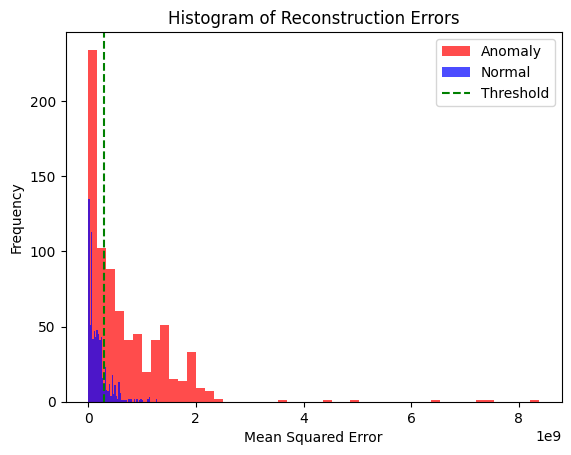

pr_auc:  0.7139141742522755
ROC AUC: 0.7416789406132633


In [83]:

reconstructed_data = vae_normal.predict(scaled_data_test)

# Calculate Mean Squared Error for each sample
mse_per_sample = np.mean(np.square(tx - reconstructed_data), axis=1)

# Separate anomalies and normal samples based on labels
anomalies = mse_per_sample[ty == 1]
normal_samples = mse_per_sample[ty == 0]

threshold = np.percentile(mse_per_sample, 60)
# Plot histogram for anomalies
plt.hist(anomalies, bins=50, color='r', alpha=0.7, label='Anomaly')

# Plot histogram for normal samples
plt.hist(normal_samples, bins=50, color='b', alpha=0.7, label='Normal')
plt.axvline(x = threshold, color='green', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#print(mse_per_sample)


# Create binary arrays indicating whether each element is anomalous or not
anomalies = np.where(mse_per_sample >threshold, 1, 0)

# Assuming you have labels for your test set (1 for anomalous, 0 for normal)
# Replace this with your actual labels
# If you don't have labeled data, you might need a different approach to set the threshold
#print("anomalies: ", anomalies)
#print(anomalies.shape)

# Calculate precision and recall
precision = precision_score(ty, anomalies)
recall = recall_score(ty, anomalies)
accuracy = accuracy_score(ty, anomalies)

fpr, tpr, thresholds = metrics.roc_curve(ty, anomalies)
pr_auc = metrics.auc(fpr, tpr)
#print(thresholds)

print("pr_auc: ",pr_auc)
print("ROC AUC:",roc_auc_score(ty, mse_per_sample))


# Dataset 6: Ozone Level

In [89]:
f=np.load("/content/drive/My Drive/Colab Notebooks/Sadia/datasets/ozone-level-8hr.npz")
data = {1: "x", 2:"y" ,3:'z'}
for (i,j) in enumerate(f):
    data[i+1] = f[j]
x_train = data[1]
tx = data[2]
ty = data[3]

In [105]:
scaler = MinMaxScaler()
scaled_data_train = scaler.fit_transform(x_train)
scaled_data_test = scaler.transform(tx)

In [108]:
initial_learning_rate = 0.0001
decay_steps = 5000
decay_rate = 0.9

input_dim = scaled_data_train.shape[1]
latent_dim = 4 # Adjust the latent dimension as needed
dropout_rate = 0.1
act_fn = "relu"
# Encoder
encoder_inputs = tf.keras.layers.Input(shape=(input_dim,))
#x = tf.keras.layers.Dense(512, activation=act_fn)(encoder_inputs)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

x = tf.keras.layers.Dense(256, activation=act_fn)(encoder_inputs)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)
x = tf.keras.layers.Dense(128, activation=act_fn)(x)
x = tf.keras.layers.Dense(64, activation=act_fn)(x)
x = tf.keras.layers.Dense(32, activation=act_fn)(x)
x = tf.keras.layers.Dense(16, activation=act_fn)(x)


x = tf.keras.layers.Dense(8, activation=act_fn)(x)
#x = tf.keras.layers.Dense(4, activation=act_fn)(x)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

z_mean = tf.keras.layers.Dense(latent_dim)(x)
z_log_var = tf.keras.layers.Dense(latent_dim)(x)

# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder
decoder_inputs = tf.keras.layers.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(8, activation=act_fn)(decoder_inputs)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)


x = tf.keras.layers.Dense(16, activation=act_fn)(x)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

x = tf.keras.layers.Dense(32, activation=act_fn)(x)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

x = tf.keras.layers.Dense(64, activation=act_fn)(x)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

x = tf.keras.layers.Dense(128, activation=act_fn)(x)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)
x = tf.keras.layers.Dense(256, activation=act_fn)(x)
#x = tf.keras.layers.Dense(512, activation=act_fn)(x)

outputs = tf.keras.layers.Dense(input_dim, activation='relu')(x)

# Instantiate the model
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z])
decoder = tf.keras.Model(decoder_inputs, outputs)
# VAE model with denoising
noise_factor = 0.1  # Adjust the level of noise as needed

# Add noise to the input during training
noisy_encoder_inputs = tf.keras.layers.GaussianNoise(stddev=noise_factor)(encoder_inputs)

# VAE model
outputs = decoder(encoder(encoder_inputs)[2])
vae_normal = tf.keras.Model(encoder_inputs, outputs)

# Define loss function
def vae_loss(inputs, outputs):
    reconstruction_loss = tf.keras.losses.mean_squared_error(inputs, outputs)

    # Accessing z_mean and z_log_var from the model's output
    z_mean = encoder(inputs)[0]
    z_log_var = encoder(inputs)[1]

    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    return 0.1*reconstruction_loss + 0.9*kl_loss

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# Compile the model
vae_normal.compile(optimizer=optimizer, loss=vae_loss)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # The metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)
# Train the model
vae_normal.fit(scaled_data_train, scaled_data_train, epochs=50, batch_size=8, validation_split=0.25, callbacks=[early_stopping])


Epoch 1/50
11/11 [==============================] - 9s 89ms/step - loss: 0.2226 - val_loss: 0.0936
Epoch 2/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0934 - val_loss: 0.0961
Epoch 3/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0713 - val_loss: 0.0593
Epoch 4/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0533 - val_loss: 0.0516
Epoch 5/50
11/11 [==============================] - 0s 11ms/step - loss: 0.0450 - val_loss: 0.0417
Epoch 6/50
11/11 [==============================] - 0s 8ms/step - loss: 0.0413 - val_loss: 0.0414
Epoch 7/50
11/11 [==============================] - 0s 10ms/step - loss: 0.0369 - val_loss: 0.0345
Epoch 8/50
11/11 [==============================] - 0s 12ms/step - loss: 0.0339 - val_loss: 0.0331
Epoch 9/50
11/11 [==============================] - 0s 9ms/step - loss: 0.0328 - val_loss: 0.0341
Epoch 10/50
11/11 [==============================] - 0s 11ms/step - loss: 0.0310 - val_loss: 0.0312
Epoch 11/50
1

3/3 [==============================] - 0s 7ms/step


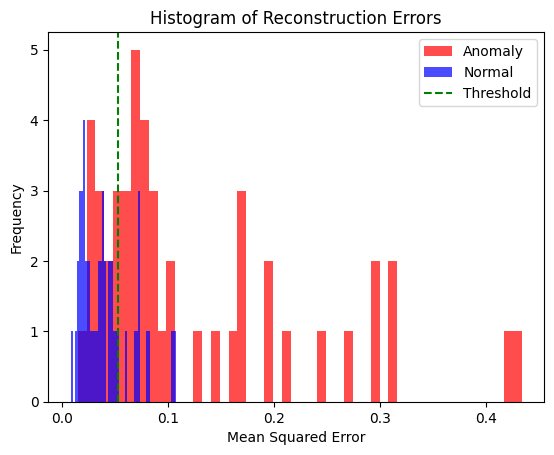

pr_auc:  0.7916666666666666
ROC AUC: 0.8315972222222222


In [110]:

reconstructed_data = vae_normal.predict(scaled_data_test)

# Calculate Mean Squared Error for each sample
mse_per_sample = np.mean(np.square(scaled_data_test - reconstructed_data), axis=1)

# Separate anomalies and normal samples based on labels
anomalies = mse_per_sample[ty == 1]
normal_samples = mse_per_sample[ty == 0]

threshold = np.percentile(mse_per_sample, 50)
# Plot histogram for anomalies
plt.hist(anomalies, bins=50, color='r', alpha=0.7, label='Anomaly')

# Plot histogram for normal samples
plt.hist(normal_samples, bins=50, color='b', alpha=0.7, label='Normal')
plt.axvline(x = threshold, color='green', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#print(mse_per_sample)


# Create binary arrays indicating whether each element is anomalous or not
anomalies = np.where(mse_per_sample >threshold, 1, 0)

# Assuming you have labels for your test set (1 for anomalous, 0 for normal)
# Replace this with your actual labels
# If you don't have labeled data, you might need a different approach to set the threshold
#print("anomalies: ", anomalies)
#print(anomalies.shape)

# Calculate precision and recall
precision = precision_score(ty, anomalies)
recall = recall_score(ty, anomalies)
accuracy = accuracy_score(ty, anomalies)

fpr, tpr, thresholds = metrics.roc_curve(ty, anomalies)
pr_auc = metrics.auc(fpr, tpr)
#print(thresholds)

print("pr_auc: ",pr_auc)
print("ROC AUC:",roc_auc_score(ty, mse_per_sample))


# Dataset 7: Vowels

In [113]:
f=np.load("/content/drive/My Drive/Colab Notebooks/Sadia/datasets/vowels.npz")
data = {1: "x", 2:"y" ,3:'z'}
for (i,j) in enumerate(f):
    data[i+1] = f[j]
x_train = data[1]
tx = data[2]
ty = data[3]

(1356, 12)

In [112]:
scaler = StandardScaler()
scaled_data_train = scaler.fit_transform(x_train)
scaled_data_test = scaler.transform(tx)

In [116]:
initial_learning_rate = 0.0001
decay_steps = 5000
decay_rate = 0.9

input_dim = scaled_data_train.shape[1]
latent_dim = 2 # Adjust the latent dimension as needed
dropout_rate = 0.1
act_fn = "relu"
# Encoder
encoder_inputs = tf.keras.layers.Input(shape=(input_dim,))
#x = tf.keras.layers.Dense(512, activation=act_fn)(encoder_inputs)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

#x = tf.keras.layers.Dense(256, activation=act_fn)(encoder_inputs)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

x = tf.keras.layers.Dense(128, activation=act_fn)(encoder_inputs)
x = tf.keras.layers.Dense(64, activation=act_fn)(x)
x = tf.keras.layers.Dense(32, activation=act_fn)(x)
x = tf.keras.layers.Dense(16, activation=act_fn)(x)


x = tf.keras.layers.Dense(8, activation=act_fn)(x)
x = tf.keras.layers.Dense(4, activation=act_fn)(x)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

z_mean = tf.keras.layers.Dense(latent_dim)(x)
z_log_var = tf.keras.layers.Dense(latent_dim)(x)

# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder
decoder_inputs = tf.keras.layers.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(4, activation=act_fn)(decoder_inputs)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)


x = tf.keras.layers.Dense(8, activation=act_fn)(x)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

x = tf.keras.layers.Dense(32, activation=act_fn)(x)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

x = tf.keras.layers.Dense(64, activation=act_fn)(x)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

x = tf.keras.layers.Dense(128, activation=act_fn)(x)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)
#x = tf.keras.layers.Dense(256, activation=act_fn)(x)

#x = tf.keras.layers.Dense(512, activation=act_fn)(x)

outputs = tf.keras.layers.Dense(input_dim, activation='linear')(x)

# Instantiate the model
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z])
decoder = tf.keras.Model(decoder_inputs, outputs)
# VAE model with denoising
noise_factor = 0.1  # Adjust the level of noise as needed

# Add noise to the input during training
noisy_encoder_inputs = tf.keras.layers.GaussianNoise(stddev=noise_factor)(encoder_inputs)

# VAE model
outputs = decoder(encoder(encoder_inputs)[2])
vae_normal = tf.keras.Model(encoder_inputs, outputs)

# Define loss function
def vae_loss(inputs, outputs):
    reconstruction_loss = tf.keras.losses.mean_squared_error(inputs, outputs)

    # Accessing z_mean and z_log_var from the model's output
    z_mean = encoder(inputs)[0]
    z_log_var = encoder(inputs)[1]

    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    return 0.1*reconstruction_loss + 0.9*kl_loss

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# Compile the model
vae_normal.compile(optimizer=optimizer, loss=vae_loss)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # The metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)
# Train the model
vae_normal.fit(scaled_data_train, scaled_data_train, epochs=50, batch_size=8, validation_split=0.25, callbacks=[early_stopping])


Epoch 1/50
128/128 [==============================] - 8s 14ms/step - loss: 0.1048 - val_loss: 0.0977
Epoch 2/50
128/128 [==============================] - 1s 5ms/step - loss: 0.1011 - val_loss: 0.0975
Epoch 3/50
128/128 [==============================] - 1s 5ms/step - loss: 0.1010 - val_loss: 0.0974
Epoch 4/50
128/128 [==============================] - 0s 4ms/step - loss: 0.1009 - val_loss: 0.0975
Epoch 5/50
128/128 [==============================] - 1s 5ms/step - loss: 0.1010 - val_loss: 0.0973
Epoch 6/50
128/128 [==============================] - 1s 4ms/step - loss: 0.1009 - val_loss: 0.0974
Epoch 7/50
128/128 [==============================] - 1s 4ms/step - loss: 0.1009 - val_loss: 0.0974
Epoch 8/50
128/128 [==============================] - 1s 5ms/step - loss: 0.1009 - val_loss: 0.0975
Epoch 9/50
128/128 [==============================] - 1s 4ms/step - loss: 0.1009 - val_loss: 0.0974
Epoch 10/50
128/128 [==============================] - 1s 5ms/step - loss: 0.1010 - val_loss: 0.097

4/4 [==============================] - 0s 4ms/step


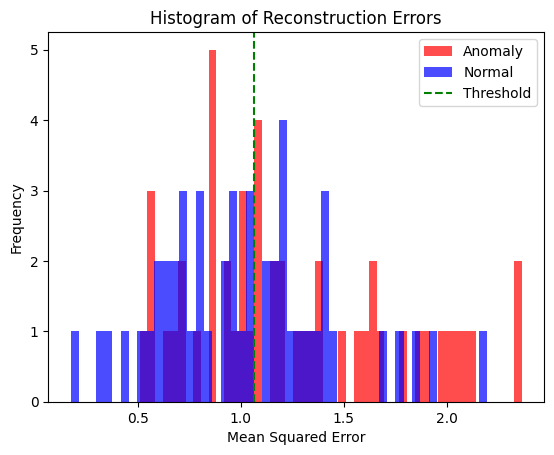

pr_auc:  0.5800000000000001
ROC AUC: 0.6256


In [117]:

reconstructed_data = vae_normal.predict(scaled_data_test)

# Calculate Mean Squared Error for each sample
mse_per_sample = np.mean(np.square(scaled_data_test - reconstructed_data), axis=1)

# Separate anomalies and normal samples based on labels
anomalies = mse_per_sample[ty == 1]
normal_samples = mse_per_sample[ty == 0]

threshold = np.percentile(mse_per_sample, 50)
# Plot histogram for anomalies
plt.hist(anomalies, bins=50, color='r', alpha=0.7, label='Anomaly')

# Plot histogram for normal samples
plt.hist(normal_samples, bins=50, color='b', alpha=0.7, label='Normal')
plt.axvline(x = threshold, color='green', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#print(mse_per_sample)


# Create binary arrays indicating whether each element is anomalous or not
anomalies = np.where(mse_per_sample >threshold, 1, 0)

# Assuming you have labels for your test set (1 for anomalous, 0 for normal)
# Replace this with your actual labels
# If you don't have labeled data, you might need a different approach to set the threshold
#print("anomalies: ", anomalies)
#print(anomalies.shape)

# Calculate precision and recall
precision = precision_score(ty, anomalies)
recall = recall_score(ty, anomalies)
accuracy = accuracy_score(ty, anomalies)

fpr, tpr, thresholds = metrics.roc_curve(ty, anomalies)
pr_auc = metrics.auc(fpr, tpr)
#print(thresholds)

print("pr_auc: ",pr_auc)
print("ROC AUC:",roc_auc_score(ty, mse_per_sample))


# Dataset 8: Waveform

In [118]:
f=np.load("/content/drive/My Drive/Colab Notebooks/Sadia/datasets/waveform-5000.npz")
data = {1: "x", 2:"y" ,3:'z'}
for (i,j) in enumerate(f):
    data[i+1] = f[j]
x_train = data[1]
tx = data[2]
ty = data[3]

In [119]:
scaler = StandardScaler()
scaled_data_train = scaler.fit_transform(x_train)
scaled_data_test = scaler.transform(tx)

In [120]:
initial_learning_rate = 0.0001
decay_steps = 5000
decay_rate = 0.9

input_dim = scaled_data_train.shape[1]
latent_dim = 2 # Adjust the latent dimension as needed
dropout_rate = 0.1
act_fn = "relu"
# Encoder
encoder_inputs = tf.keras.layers.Input(shape=(input_dim,))
#x = tf.keras.layers.Dense(512, activation=act_fn)(encoder_inputs)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

#x = tf.keras.layers.Dense(256, activation=act_fn)(encoder_inputs)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

x = tf.keras.layers.Dense(128, activation=act_fn)(encoder_inputs)
x = tf.keras.layers.Dense(64, activation=act_fn)(x)
x = tf.keras.layers.Dense(32, activation=act_fn)(x)
x = tf.keras.layers.Dense(16, activation=act_fn)(x)


x = tf.keras.layers.Dense(8, activation=act_fn)(x)
x = tf.keras.layers.Dense(4, activation=act_fn)(x)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

z_mean = tf.keras.layers.Dense(latent_dim)(x)
z_log_var = tf.keras.layers.Dense(latent_dim)(x)

# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder
decoder_inputs = tf.keras.layers.Input(shape=(latent_dim,))
x = tf.keras.layers.Dense(4, activation=act_fn)(decoder_inputs)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)


x = tf.keras.layers.Dense(8, activation=act_fn)(x)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

x = tf.keras.layers.Dense(32, activation=act_fn)(x)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

x = tf.keras.layers.Dense(64, activation=act_fn)(x)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)

x = tf.keras.layers.Dense(128, activation=act_fn)(x)
#x = tf.keras.layers.GaussianDropout(rate=dropout_rate)(x)
#x = tf.keras.layers.Dense(256, activation=act_fn)(x)

#x = tf.keras.layers.Dense(512, activation=act_fn)(x)

outputs = tf.keras.layers.Dense(input_dim, activation='linear')(x)

# Instantiate the model
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z])
decoder = tf.keras.Model(decoder_inputs, outputs)
# VAE model with denoising
noise_factor = 0.1  # Adjust the level of noise as needed

# Add noise to the input during training
noisy_encoder_inputs = tf.keras.layers.GaussianNoise(stddev=noise_factor)(encoder_inputs)

# VAE model
outputs = decoder(encoder(encoder_inputs)[2])
vae_normal = tf.keras.Model(encoder_inputs, outputs)

# Define loss function
def vae_loss(inputs, outputs):
    reconstruction_loss = tf.keras.losses.mean_squared_error(inputs, outputs)

    # Accessing z_mean and z_log_var from the model's output
    z_mean = encoder(inputs)[0]
    z_log_var = encoder(inputs)[1]

    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    return 0.1*reconstruction_loss + 0.9*kl_loss

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# Compile the model
vae_normal.compile(optimizer=optimizer, loss=vae_loss)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # The metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)
# Train the model
vae_normal.fit(scaled_data_train, scaled_data_train, epochs=50, batch_size=8, validation_split=0.25, callbacks=[early_stopping])


Epoch 1/50
111/111 [==============================] - 5s 12ms/step - loss: 0.1080 - val_loss: 0.1012
Epoch 2/50
111/111 [==============================] - 1s 10ms/step - loss: 0.1013 - val_loss: 0.1001
Epoch 3/50
111/111 [==============================] - 1s 12ms/step - loss: 0.1007 - val_loss: 0.0999
Epoch 4/50
111/111 [==============================] - 1s 9ms/step - loss: 0.1005 - val_loss: 0.0998
Epoch 5/50
111/111 [==============================] - 1s 8ms/step - loss: 0.1004 - val_loss: 0.0997
Epoch 6/50
111/111 [==============================] - 1s 8ms/step - loss: 0.1004 - val_loss: 0.0997
Epoch 7/50
111/111 [==============================] - 1s 7ms/step - loss: 0.1004 - val_loss: 0.0997
Epoch 8/50
111/111 [==============================] - 1s 7ms/step - loss: 0.1003 - val_loss: 0.0997
Epoch 9/50
111/111 [==============================] - 1s 7ms/step - loss: 0.1003 - val_loss: 0.0997
Epoch 10/50
111/111 [==============================] - 1s 7ms/step - loss: 0.1003 - val_loss: 0.0

32/32 [==============================] - 0s 3ms/step


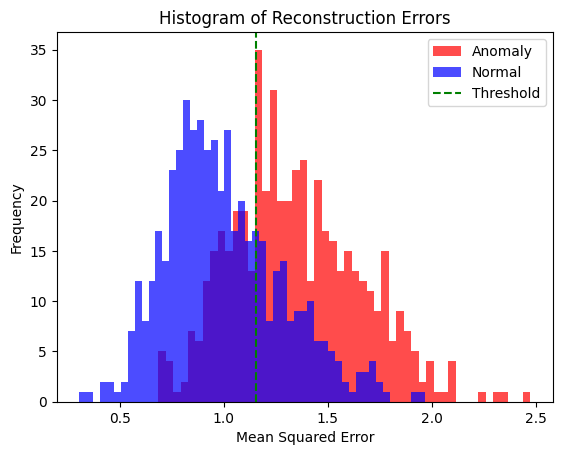

pr_auc:  0.7238658777120315
ROC AUC: 0.8013725009628515


In [121]:

reconstructed_data = vae_normal.predict(scaled_data_test)

# Calculate Mean Squared Error for each sample
mse_per_sample = np.mean(np.square(scaled_data_test - reconstructed_data), axis=1)

# Separate anomalies and normal samples based on labels
anomalies = mse_per_sample[ty == 1]
normal_samples = mse_per_sample[ty == 0]

threshold = np.percentile(mse_per_sample, 50)
# Plot histogram for anomalies
plt.hist(anomalies, bins=50, color='r', alpha=0.7, label='Anomaly')

# Plot histogram for normal samples
plt.hist(normal_samples, bins=50, color='b', alpha=0.7, label='Normal')
plt.axvline(x = threshold, color='green', linestyle='--', label='Threshold')
plt.title('Histogram of Reconstruction Errors')
plt.xlabel('Mean Squared Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#print(mse_per_sample)


# Create binary arrays indicating whether each element is anomalous or not
anomalies = np.where(mse_per_sample >threshold, 1, 0)

# Assuming you have labels for your test set (1 for anomalous, 0 for normal)
# Replace this with your actual labels
# If you don't have labeled data, you might need a different approach to set the threshold
#print("anomalies: ", anomalies)
#print(anomalies.shape)

# Calculate precision and recall
precision = precision_score(ty, anomalies)
recall = recall_score(ty, anomalies)
accuracy = accuracy_score(ty, anomalies)

fpr, tpr, thresholds = metrics.roc_curve(ty, anomalies)
pr_auc = metrics.auc(fpr, tpr)
#print(thresholds)

print("pr_auc: ",pr_auc)
print("ROC AUC:",roc_auc_score(ty, mse_per_sample))
